In [2]:
import geopandas as gpd
import osmnx as ox
import folium
import numpy as np
import pandas as pd
import math
import requests
from PIL import Image
import time
from selenium import webdriver 
from shapely.geometry import *
from shapely.affinity import rotate, scale
from shapely.ops import linemerge, unary_union
from collections import defaultdict
from IPython.display import display
import os 
import matplotlib.pyplot as plt

%matplotlib inline
import pickle

In [65]:
# Initial location and distance
location_point = (51.50212855505546, -0.19123200203284765)
dist = 3000

# Extract graph and building data for the initial location
G = ox.graph.graph_from_point(location_point, dist=dist, dist_type="bbox", network_type="drive")
buildings = ox.features.features_from_point(location_point, tags={'building': True}, dist=dist * 1.1)

# Calculate the offset in degrees longitude for 4000 meters to the east
meters_to_east = 4000
latitude_rad = math.radians(location_point[0])
longitude_offset = meters_to_east / (111320 * math.cos(latitude_rad))

# New center point 4000 meters to the east of the original location
new_location_point = (location_point[0], location_point[1] + longitude_offset)

# Extract graph and building data for the new location
new_dist = 1000
G_test = ox.graph.graph_from_point(new_location_point, dist=new_dist, dist_type="bbox", network_type="drive")
buildings_test = ox.features.features_from_point(new_location_point, tags={'building': True}, dist=new_dist * 1.1)

/home/zach/anaconda3/envs/ox/lib/python3.12/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(
/home/zach/anaconda3/envs/ox/lib/python3.12/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


# Load Traffic Accident Data

In [66]:
column_types = {
    'Accident_Index': str,
    'LSOA_of_Accident_Location': str,
    'Longitude': float,
    'Latitude': float,
    # Add other columns with specific types here
    # You may set specific columns to `str` to avoid mixed types warning
}
uk1979 = pd.read_csv("data/dft-road-casualty-statistics-collision-1979-latest-published-year.csv", dtype=column_types)
uk2022 = pd.read_csv("data/dft-road-casualty-statistics-collision-2022.csv", dtype=column_types)
uk2023 = pd.read_csv("data/dft-road-casualty-statistics-collision-provisional-mid-year-unvalidated-2023.csv", dtype=column_types)
uk2023.rename(columns={
    'collision_index': 'accident_index',
    'collision_year': 'accident_year',
    'collision_reference': 'accident_reference',
    'legacy_collision_severity': 'accident_severity',
    'did_police_officer_attend_scene_of_collision': 'did_police_officer_attend_scene_of_accident',
    'lsoa_of_collision_location': 'lsoa_of_accident_location'
}, inplace=True)
uk2023 = uk2023[uk2022.columns]
# Concatenate the DataFrames
uk_acc = pd.concat([uk1979, uk2022, uk2023], ignore_index=True)
del uk1979, uk2022, uk2023

/tmp/ipykernel_6161/4290456704.py:9: DtypeWarning: Columns (0,2,15,16,35) have mixed types. Specify dtype option on import or set low_memory=False.
  uk1979 = pd.read_csv("data/dft-road-casualty-statistics-collision-1979-latest-published-year.csv", dtype=column_types)
/tmp/ipykernel_6161/4290456704.py:10: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  uk2022 = pd.read_csv("data/dft-road-casualty-statistics-collision-2022.csv", dtype=column_types)
/tmp/ipykernel_6161/4290456704.py:11: DtypeWarning: Columns (0,2,35) have mixed types. Specify dtype option on import or set low_memory=False.
  uk2023 = pd.read_csv("data/dft-road-casualty-statistics-collision-provisional-mid-year-unvalidated-2023.csv", dtype=column_types)


In [67]:
traffic = pd.read_csv("data/dft_traffic_counts_aadf.csv")
traffic_grouped = traffic.groupby('count_point_id').agg({
    'latitude': 'first',        # Get the first latitude for the point
    'longitude': 'first',       # Get the first longitude for the point
    'all_motor_vehicles': 'mean'  # Average traffic count across years
}).reset_index()

/tmp/ipykernel_6161/2431722876.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  traffic = pd.read_csv("data/dft_traffic_counts_aadf.csv")


In [ ]:
# Convert the graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)
nodes_test, edges_test = ox.graph_to_gdfs(G_test)
# Convert the traffic data to a GeoDataFrame
traffic_grouped['geometry'] = traffic_grouped.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
traffic_gdf = gpd.GeoDataFrame(traffic_grouped, geometry='geometry')

# Ensure both GeoDataFrames are in the same coordinate reference system (CRS)
edges = edges.to_crs(epsg=4326)
traffic_gdf = traffic_gdf.set_crs(epsg=4326)

# Step 2: Perform a spatial join to find the nearest traffic count point for each edge
edges['traffic_count'] = None  # Initialize a column for traffic count

for i, edge in edges.iterrows():
    # Calculate the distance to each traffic count point
    distances = traffic_gdf.distance(edge.geometry.centroid)
    nearest_point_index = distances.idxmin()  # Find the index of the nearest point
    
    # Assign the nearest traffic count to the edge
    edges.at[i, 'traffic_count'] = traffic_gdf.loc[nearest_point_index, 'all_motor_vehicles']

# Step 3: (Optional) Fill any NaN values in 'traffic_count' with 0 or another value
edges['traffic_count'] = edges['traffic_count'].fillna(0)
edges['traffic_count_log'] = np.log1p(edges['traffic_count'])  # log1p is used to handle zero counts

# Min-max normalization after log transformation
min_log_traffic = edges['traffic_count_log'].min()
max_log_traffic = edges['traffic_count_log'].max()

edges['traffic_count_log_normalized'] = (edges['traffic_count_log'] - min_log_traffic) / (max_log_traffic - min_log_traffic)

# Create geometry for the accident data
geometry = [Point(xy) for xy in zip(uk_acc["longitude"], uk_acc["latitude"])]
uk_acc_gdf = gpd.GeoDataFrame(uk_acc, crs="EPSG:4326", geometry=geometry)

# Clean up the edges DataFrame
edges['width'] = edges['width'].apply(lambda x: x if isinstance(x, tuple) else (0, 0))
edges['lanes'] = edges['lanes'].apply(lambda x: x if isinstance(x, str) else "1")


# Data Preparation

In [114]:
# Create the base Folium map centered at a generic location
m = folium.Map(location=(51.509865, -0.118092), zoom_start=18)  # Central London as an example

# Add the Mapbox Satellite tile layer once
mapbox_url = f'https://api.mapbox.com/v4/mapbox.satellite/{{z}}/{{x}}/{{y}}@2x.png?access_token='
folium.TileLayer(
    tiles=mapbox_url,
    attr='Mapbox',
    name='Mapbox Satellite',
    overlay=True,
    control=True
).add_to(m)

# Define the output directory
output_dir = "train_data"

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the side length for the square in degrees
side_length_lat = 0.002  # Approximate latitude span

# Define the side length for the square in degrees
all_heatmaps = []
# # Define the side length for the square in degrees


# Iterate over all nodes
for inter_index, row in tqdm(nodes.iterrows(), total=nodes.shape[0]):
    # Define the center point in latitude and longitude
    center_lat, center_lon = nodes.loc[inter_index].y, nodes.loc[inter_index].x
    center_point = Point(center_lon, center_lat)

    # Adjust longitude span based on latitude
    scaling_factor = 1 / np.cos(np.radians(center_lat))
    side_length_lon = side_length_lat * scaling_factor

    # Create a square boundary around the center point
    minx = center_lon - side_length_lon / 2
    miny = center_lat - side_length_lat / 2
    maxx = center_lon + side_length_lon / 2
    maxy = center_lat + side_length_lat / 2
    boundaries = box(minx, miny, maxx, maxy)

    # # Update the map bounds for the current node
    # m.fit_bounds([[miny, minx], [maxy, maxx]])

    # # Save the map as an HTML file temporarily
    # map_path = f"map_{inter_index}.html"
    # m.save(map_path)

    # # Capture the map screenshot
    # driver = webdriver.Chrome()  # Ensure ChromeDriver is installed and in your PATH
    # driver.set_window_size(1024, 1024)  # Set the window size to what you need
    # driver.get("file://" + os.path.abspath(map_path))  # Load the map HTML file

    # # Give it some time to fully load all elements
    # time.sleep(1)

    # # Save a screenshot
    # screenshot_path = f"map_{inter_index}.png"
    # driver.save_screenshot(screenshot_path)

    # # Close the browser
    # driver.quit()

    # # Crop the screenshot to focus on the node
    # x1, y1, x2, y2 = 195, 125, 790, 720
    # image = Image.open(screenshot_path)
    # image = image.crop((x1, y1, x2, y2))  # Adjust the crop box as needed

    # # Save the cropped image under the output directory
    # cropped_image_path = os.path.join(output_dir, f"{inter_index}_satellite.png")
    # image.save(cropped_image_path)

    # # Update the output shape based on the cropped image dimensions
    # output_shape = (y2 - y1, x2 - x1)

    # # Rasterize buildings
    # building_list = [i for i in buildings.geometry if i.intersects(boundaries)]
    # build_cut = unary_union(building_list).intersection(boundaries)
    # transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, output_shape[1], output_shape[0])
    # building_array = rasterio.features.rasterize(
    #     [(mapping(build_cut), 1)],
    #     out_shape=output_shape,
    #     transform=transform,
    #     fill=0,
    #     dtype=np.uint8
    # )

    # # Save the building raster as a .npy file
    # building_npy_filename = os.path.join(output_dir, f"{inter_index}_building.npy")
    # np.save(building_npy_filename, building_array)

    # Create accident heatmap
    accidents_within_boundary = uk_acc_gdf[uk_acc_gdf["geometry"].within(boundaries)]
    heatmap = np.zeros(output_shape)
    for accident in accidents_within_boundary.geometry:
        # Correct x and y indices for the aspect ratio
        x_idx = int((accident.x - minx) / (maxx - minx) * output_shape[1])
        y_idx = int((maxy - accident.y) / (maxy - miny) * output_shape[0])
        
        # Plot each accident as a red dot
        if 0 <= x_idx < output_shape[1] and 0 <= y_idx < output_shape[0]:
            heatmap[y_idx, x_idx] += 1
    all_heatmaps.append(heatmap)
    # Save the traffic density raster as a PNG file for visual verification
    # traffic_png_filename = os.path.join(output_dir, f"{inter_index}_traffic.png")
    # plt.imsave(traffic_png_filename, gaussian_filter(heatmap, sigma=15), cmap='hot')
    # traffic_array = np.zeros(output_shape)

    # Filter edges within the boundaries
    # edges_within_boundaries = edges[edges.intersects(boundaries)]

    # for i, road_segment in edges_within_boundaries.iterrows():
    #     if road_segment.geometry.intersects(boundaries):
    #         # Use the normalized traffic count from the edge
    #         segment_traffic_count = road_segment['traffic_count_log_normalized']
            
    #         # Buffer the road segment and intersect with boundaries
    #         road_buffered = road_segment.geometry.buffer(0.0001).intersection(boundaries)
            
    #         # Rasterize the buffered road segment
    #         road_mask = rasterio.features.rasterize(
    #             [(mapping(road_buffered), segment_traffic_count)],
    #             out_shape=output_shape,
    #             transform=transform,
    #             fill=0,
    #             dtype=np.float32
    #         )
            
    #         # Use maximum value to combine the traffic data into the traffic_array
    #         traffic_array = np.maximum(traffic_array, road_mask)

    # # Save the traffic density raster as a .npy file
    # traffic_npy_filename = os.path.join(output_dir, f"{inter_index}_traffic.npy")
    # np.save(traffic_npy_filename, traffic_array)


    # Remove temporary files (screenshot and HTML)
    # os.remove(screenshot_path)
    # os.remove(map_path)


100%|██████████| 5097/5097 [17:00<00:00,  5.00it/s]


In [122]:
# Process each heatmap in a single loop
for idx, heatmap in enumerate(all_heatmaps):
    # Log-transform the heatmap to handle the Poisson-like distribution
    log_transformed_heatmap = np.log1p(heatmap)

    # Apply Gaussian smoothing to the log-transformed heatmap
    smoothed_log_heatmap = gaussian_filter(log_transformed_heatmap, sigma=15)

    # Find the maximum for this specific heatmap
    local_max = smoothed_log_heatmap.max()

    if local_max > 0:
        # Normalize the smoothed heatmap individually
        smoothed_log_heatmap /= local_max
    else:
        # If the maximum is not greater than zero, handle it appropriately (e.g., log a warning or set to zeros)
        print(f"Warning: Heatmap {idx} has a max value of {local_max}, skipping normalization.")
        smoothed_log_heatmap.fill(0)  # Set all values to zero if the max is zero or less

    # Save the normalized heatmap as a .npy file
    heatmap_npy_filename = os.path.join('train_data', f"{nodes.index[idx]}_heatmap.npy")
    np.save(heatmap_npy_filename, smoothed_log_heatmap)


In [115]:
# Create the base Folium map centered at a generic location
m = folium.Map(location=(51.509865, -0.118092), zoom_start=18)  # Central London as an example

# Add the Mapbox Satellite tile layer once
folium.TileLayer(
    tiles=mapbox_url,
    attr='Mapbox',
    name='Mapbox Satellite',
    overlay=True,
    control=True
).add_to(m)

# Define the output directory
output_dir = "test_data"

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the side length for the square in degrees
side_length_lat = 0.002  # Approximate latitude span

# Define the side length for the square in degrees
all_heatmaps_test = []
# # Define the side length for the square in degrees


# Iterate over all nodes
for inter_index, row in tqdm(nodes_test.iterrows(), total=nodes_test.shape[0]):
    # Define the center point in latitude and longitude
    center_lat, center_lon = nodes_test.loc[inter_index].y, nodes_test.loc[inter_index].x
    center_point = Point(center_lon, center_lat)

    # Adjust longitude span based on latitude
    scaling_factor = 1 / np.cos(np.radians(center_lat))
    side_length_lon = side_length_lat * scaling_factor

    # Create a square boundary around the center point
    minx = center_lon - side_length_lon / 2
    miny = center_lat - side_length_lat / 2
    maxx = center_lon + side_length_lon / 2
    maxy = center_lat + side_length_lat / 2
    boundaries = box(minx, miny, maxx, maxy)

    # # Update the map bounds for the current node
    # m.fit_bounds([[miny, minx], [maxy, maxx]])

    # # Save the map as an HTML file temporarily
    # map_path = f"map_{inter_index}.html"
    # m.save(map_path)

    # # Capture the map screenshot
    # driver = webdriver.Chrome()  # Ensure ChromeDriver is installed and in your PATH
    # driver.set_window_size(1024, 1024)  # Set the window size to what you need
    # driver.get("file://" + os.path.abspath(map_path))  # Load the map HTML file

    # # Give it some time to fully load all elements
    # time.sleep(1)

    # # Save a screenshot
    # screenshot_path = f"map_{inter_index}.png"
    # driver.save_screenshot(screenshot_path)

    # # Close the browser
    # driver.quit()

    # # Crop the screenshot to focus on the node
    # x1, y1, x2, y2 = 195, 125, 790, 720
    # image = Image.open(screenshot_path)
    # image = image.crop((x1, y1, x2, y2))  # Adjust the crop box as needed

    # # Save the cropped image under the output directory
    # cropped_image_path = os.path.join(output_dir, f"{inter_index}_satellite.png")
    # image.save(cropped_image_path)

    # # Update the output shape based on the cropped image dimensions
    # output_shape = (y2 - y1, x2 - x1)

    # # Rasterize buildings
    # building_list = [i for i in buildings_test.geometry if i.intersects(boundaries)]
    # build_cut = unary_union(building_list).intersection(boundaries)
    # transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, output_shape[1], output_shape[0])
    # building_array = rasterio.features.rasterize(
    #     [(mapping(build_cut), 1)],
    #     out_shape=output_shape,
    #     transform=transform,
    #     fill=0,
    #     dtype=np.uint8
    # )

    # # Save the building raster as a .npy file
    # building_npy_filename = os.path.join(output_dir, f"{inter_index}_building.npy")
    # np.save(building_npy_filename, building_array)

    # Create accident heatmap
    accidents_within_boundary = uk_acc_gdf[uk_acc_gdf["geometry"].within(boundaries)]
    heatmap = np.zeros(output_shape)
    for accident in accidents_within_boundary.geometry:
        # Correct x and y indices for the aspect ratio
        x_idx = int((accident.x - minx) / (maxx - minx) * output_shape[1])
        y_idx = int((maxy - accident.y) / (maxy - miny) * output_shape[0])
        
        # Plot each accident as a red dot
        if 0 <= x_idx < output_shape[1] and 0 <= y_idx < output_shape[0]:
            heatmap[y_idx, x_idx] += 1
    all_heatmaps_test.append(heatmap)
    # Save the traffic density raster as a PNG file for visual verification
    # traffic_png_filename = os.path.join(output_dir, f"{inter_index}_traffic.png")
    # plt.imsave(traffic_png_filename, gaussian_filter(heatmap, sigma=15), cmap='hot')
    # traffic_array = np.zeros(output_shape)

    # Filter edges within the boundaries
    # edges_within_boundaries = edges_test[edges_test.intersects(boundaries)]

    # for i, road_segment in edges_within_boundaries.iterrows():
    #     if road_segment.geometry.intersects(boundaries):
    #         # Use the normalized traffic count from the edge
    #         segment_traffic_count = road_segment['traffic_count_log_normalized']
            
    #         # Buffer the road segment and intersect with boundaries
    #         road_buffered = road_segment.geometry.buffer(0.0001).intersection(boundaries)
            
    #         # Rasterize the buffered road segment
    #         road_mask = rasterio.features.rasterize(
    #             [(mapping(road_buffered), segment_traffic_count)],
    #             out_shape=output_shape,
    #             transform=transform,
    #             fill=0,
    #             dtype=np.float32
    #         )
            
    #         # Use maximum value to combine the traffic data into the traffic_array
    #         traffic_array = np.maximum(traffic_array, road_mask)

    # # Save the traffic density raster as a .npy file
    # traffic_npy_filename = os.path.join(output_dir, f"{inter_index}_traffic.npy")
    # np.save(traffic_npy_filename, traffic_array)


    # Remove temporary files (screenshot and HTML)
    # os.remove(screenshot_path)
    # os.remove(map_path)


100%|██████████| 600/600 [01:57<00:00,  5.11it/s]


In [118]:
# Process each heatmap in a single loop
for idx, heatmap in enumerate(all_heatmaps_test):
    # Log-transform the heatmap to handle the Poisson-like distribution
    log_transformed_heatmap = np.log1p(heatmap)

    # Apply Gaussian smoothing to the log-transformed heatmap
    smoothed_log_heatmap = gaussian_filter(log_transformed_heatmap, sigma=15)

    # Normalize the smoothed heatmap individually
    smoothed_log_heatmap /= smoothed_log_heatmap.max()

    # Save the normalized heatmap as a .npy file
    heatmap_npy_filename = os.path.join('test_data', f"{nodes_test.index[idx]}_heatmap.npy")
    np.save(heatmap_npy_filename, smoothed_log_heatmap)


# display buildings over GIS data

/home/zach/anaconda3/envs/ox/lib/python3.12/subprocess.py:1127: ResourceWarning: subprocess 267740 is still running
  _warn("subprocess %s is still running" % self.pid,


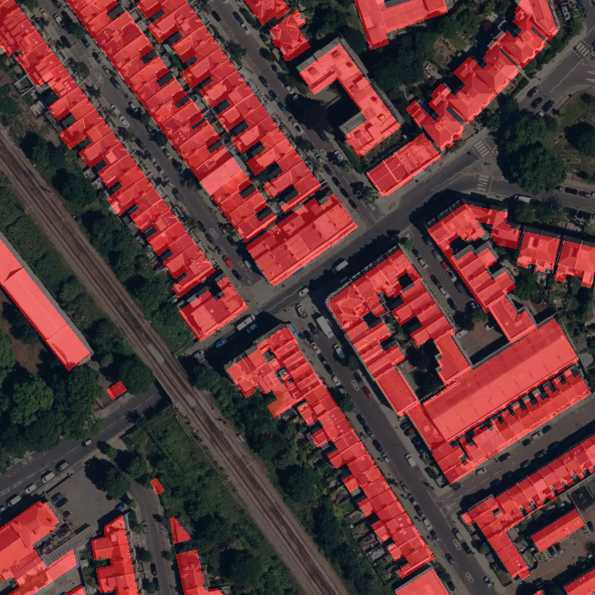

In [33]:
import geopandas as gpd
import numpy as np
import rasterio.features
from shapely.geometry import box, mapping
import matplotlib.pyplot as plt
from PIL import Image
inter_index = nodes.index[240]
# Define the center point in latitude and longitude
center_lat, center_lon = nodes.loc[inter_index].y, nodes.loc[inter_index].x
center_point = Point(center_lon, center_lat)

# Define the side length for the square in degrees
side_length_lat = 0.002  # Approximate latitude span
scaling_factor = 1 / np.cos(np.radians(center_lat))
side_length_lon = side_length_lat * scaling_factor  # Adjust longitude span

# Create a square boundary around the center point
minx = center_lon - side_length_lon / 2
miny = center_lat - side_length_lat / 2
maxx = center_lon + side_length_lon / 2
maxy = center_lat + side_length_lat / 2
boundaries = box(minx, miny, maxx, maxy)

# Get the buildings within the boundaries
building_list = [i for i in buildings.geometry if i.intersects(boundaries)]
building_union = unary_union(building_list)
build_cut = building_union.intersection(boundaries)

x1 = 195
y1 = 125
x2 = 790
y2 = 720
# Load the cropped image (this should be the satellite screenshot)
m = folium.Map(location=location_point, zoom_start=15)

# Add the Mapbox Satellite tile layer

folium.TileLayer(
    tiles=mapbox_url,
    attr='Mapbox',
    name='Mapbox Satellite',
    overlay=True,
    control=True
).add_to(m)
# Set map bounds based on the bounding box
m.fit_bounds([[miny, minx], [maxy, maxx]])

# Save the map as an HTML file temporarily
map_path = "map.html"
m.save(map_path)
driver = webdriver.Chrome()  # Ensure ChromeDriver is installed and in your PATH
driver.set_window_size(1024, 1024)  # Set the window size to what you need
driver.get("file://" + os.path.abspath(map_path))  # Load the map HTML file

# Give it some time to fully load all elements
time.sleep(1)

# Save a screenshot
screenshot_path = "map.png"
driver.save_screenshot(screenshot_path)

# Close the browser
driver.quit()

image = Image.open(screenshot_path)
image = image.crop((x1, y1, x2, y2))  # Adjust the crop box as needed

# Define the output array size
output_shape = (x2-x1, y2-y1)

# Rasterize the building geometry to a binary mask
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, output_shape[1], output_shape[0])
building_array = rasterio.features.rasterize(
    [(mapping(build_cut), 1)],
    out_shape=output_shape,
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# Convert the image to a numpy array for overlaying
image_array = np.array(image)
overlay_alpha = 0.5  # Transparency level for the overlay
overlay_color = np.array([255, 0, 0], dtype=np.uint8)  # Red color for the building overlay

overlay = np.zeros_like(image_array)
for i in range(3):  # For each color channel (R, G, B)
    overlay[..., i] = building_array * overlay_color[i]

# Combine the original image with the overlay
combined = image_array.copy()
combined = np.clip((1 - overlay_alpha) * combined + overlay_alpha * overlay, 0, 255).astype(np.uint8)

# Convert back to an image and display
combined_image = Image.fromarray(combined)
combined_image.show()

# Display the combined image in Jupyter
display(combined_image)


# Display Heatmap of Traffic Accidents

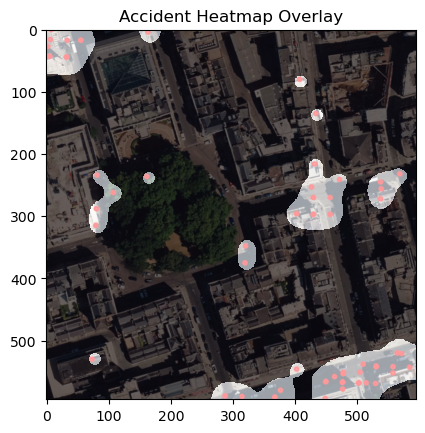

In [149]:
from scipy.ndimage import gaussian_filter

inter_index = nodes.index[9]
# Define the center point in latitude and longitude
center_lat, center_lon = nodes.loc[inter_index].y, nodes.loc[inter_index].x
center_point = Point(center_lon, center_lat)

# Define the side length for the square in degrees
side_length_lat = 0.002  # Approximate latitude span
scaling_factor = 1 / np.cos(np.radians(center_lat))
side_length_lon = side_length_lat * scaling_factor  # Adjust longitude span

# Create a square boundary around the center point
minx = center_lon - side_length_lon / 2
miny = center_lat - side_length_lat / 2
maxx = center_lon + side_length_lon / 2
maxy = center_lat + side_length_lat / 2
boundaries = box(minx, miny, maxx, maxy)

# Set cropping coordinates based on previous example
x1 = 195
y1 = 125
x2 = 790
y2 = 720


# Add the Mapbox Satellite tile layer
accidents_within_boundary = uk_acc_gdf[uk_acc_gdf["geometry"].within(boundaries)]

# Create a Folium map centered on the intersection
m = folium.Map(location=[center_lat, center_lon], zoom_start=15)

# Add the Mapbox Satellite tile layer
folium.TileLayer(
    tiles=mapbox_url,
    attr='Mapbox',
    name='Mapbox Satellite',
    overlay=True,
    control=True
).add_to(m)

# Add each accident to the map as a circle marker
for accident in accidents_within_boundary.geometry:
    folium.CircleMarker(
        location=[accident.y, accident.x],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)
# Set map bounds based on the bounding box
m.fit_bounds([[miny, minx], [maxy, maxx]])
# Save the map as an HTML file temporarily
map_path = "map.html"
m.save(map_path)
driver = webdriver.Chrome()  # Ensure ChromeDriver is installed and in your PATH
driver.set_window_size(1024, 1024)  # Set the window size to what you need
driver.get("file://" + os.path.abspath(map_path))  # Load the map HTML file

# Give it some time to fully load all elements
time.sleep(1)

# Save a screenshot
screenshot_path = "map.png"
driver.save_screenshot(screenshot_path)

# Close the browser
driver.quit()

image = Image.open(screenshot_path)
image = image.crop((x1, y1, x2, y2))  # Adjust the crop box as needed

# Define the output array size
output_shape = (x2 - x1, y2 - y1)  # Adjust to your needs
heatmap = np.zeros(output_shape)

heatmap_smooth = np.load(f'train_data/{inter_index}_heatmap.npy')# Convert the image to a numpy array for overlaying
image_array = np.array(image)
flattened_heatmap = heatmap_smooth.flatten()

# Calculate the 75th percentile to determine the threshold
threshold = np.percentile(flattened_heatmap, 90)

# Apply thresholding to identify high-risk zones
high_risk_zone = heatmap_smooth >= threshold
# Display the combined image and heatmap
plt.imshow(image_array)
plt.imshow(high_risk_zone, cmap='hot', alpha=0.6, interpolation='nearest')
#plt.imshow(heatmap_smooth, cmap='hot', alpha=0.8, interpolation='nearest')  # Overlay heatmap with some transparency

plt.title('Accident Heatmap Overlay')
plt.show()


In [79]:
heatmap_smooth.max()

0.3053346814639003

In [127]:
inter_index = nodes.index[10]
heatmap_smooth = np.load(f'train_data/{inter_index}_heatmap.npy')# Convert the image to a numpy array for overlaying
heatmap_smooth.max()

1.0

In [128]:
inter_index = nodes_test.index[10]
heatmap_smooth = np.load(f'test_data/{inter_index}_heatmap.npy')# Convert the image to a numpy array for overlaying
heatmap_smooth.max()

1.0